In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
import scipy.stats
from statsmodels.api import families

In [2]:
# set directory
os.chdir(os.getcwd().strip('notebooks'))

## Property internal features analysis 

In this Section we will be examining the correlation of property internal features, such as property type, number of beds/baths/parking to the rental price of the properties. Relevant features will be selected for modelling in the next stage

In [3]:
# read in cleaned rental properties
rental_data =pd.read_csv('data/curated/rental_properties_cleaned.csv')

In [4]:
# drop irrelevant columns
rental_data.drop(columns = ['Unnamed: 0.1', 'index'], inplace = True)

In [5]:
# factorize certain columns
rental_data.share_flag = rental_data.share_flag.astype('category')

In [7]:
# examine the correlation between the internal attributes of rental property; numerical
corr = rental_data.corr()
# corr.style.background_gradient(cmap='coolwarm')

Many of the features appear to be highly correlated with one another and not correlated with the response variable, we will drop all of these

In [8]:
# many of the features are correlated, we will drop correlated features that also have low correlation with response variable
rental_data.drop(columns = ['beds', 'parking', 'under 20 (%)', '20 - 39 (%)', '40 - 59 (%)', '60 +(%)'], inplace = True)

In [9]:
# correlation between categorical atts 
# function borrowed from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
from scipy.stats import chi2_contingency
import association_metrics as am
# function to calculate cramer's v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [10]:
# define categorical variables
rental_categorical = rental_data[['share_flag', 'property_type']].astype('category')

In [11]:
# Initialize a CramersV object 
cramers_v = am.CramersV(rental_categorical)
# It will return a pairwise matrix filled with Cramer's V, where 
# columns and index are the categorical variables of the passed     # pandas.DataFrame
cfit = cramers_v.fit().round(2)
# cfit

### Modelling (reduced)

The only features that remain after selection are: property type, share flag and number of bedrooms. We will explore these possible predictors with a few statistical models in this section 

In [12]:
# generate a simple linear model
fit_OLS = ols(
   formula = "cost_text ~ share_flag + property_type + baths", data = rental_data
).fit()

In [14]:
# check the fit of the model
# fit_OLS.summary()

In [20]:
# plot residuals of the models
fig = plt.figure(figsize=(6,3))
headerfont = {'fontname':'Arial', 'fontsize':12}
plt.rcParams['figure.dpi'] = 360 # increase sharpness of chart
plt.gcf().subplots_adjust(bottom=0.15, left = 0.3)
ax = plt.subplot(111)
graph_DO = scipy.stats.probplot(fit_OLS.resid, plot=plt)
plt.close()
# plt.show()

In [19]:
# residuals show heavy tails, perhaps a negative binomial model is more suitable?
fit_NB= glm(
    formula = "cost_text ~ share_flag + property_type + baths", data = rental_data,
    family=families.NegativeBinomial()
).fit()


In [17]:
# fit_NB.summary()

In [31]:
# perform an anova on the linear regression model
anova_table = sm.stats.anova_lm(fit_OLS)

In [21]:
# from the anova table, it appears that all features selected in this section are significant
# anova_table

This section's analysis and modelling results suggest that the number of baths, property type and whether the property is shared or not is significant to the rental prices of the property. However, it appears that the variables are too simplistic on their own as predictors. Hence we will explore other external factors but retain these three features for our final modelling

## SA2 specific features analysis

In [23]:
# read in all SA2 specific features
SA2_features_raw = pd.read_csv('data/curated/external_features(SA2).csv')

In [24]:
# replace string values
SA2_features_raw = SA2_features_raw.replace(['np'],'0')

# drop na values
SA2_features_raw.dropna(inplace = True)

In [25]:
# make a copy to look at numerical values
SA2_features = SA2_features_raw.copy()
# drop irrelevant columns
SA2_features.drop(columns = ['pop_2021', 'Unnamed: 0','property_type','LGA code','SA2 code','SA2 name'], inplace = True)

In [26]:
# convert all columns to numerical 
for column in SA2_features.columns:
    # print(column)
    SA2_features[column]=SA2_features[column].astype(float)

In [28]:
# examine the correlation between the internal attributes of rental property; numerical
corr_2 = SA2_features .corr()
# corr_2.style.background_gradient(cmap='coolwarm')

Disappointingly, only mean income seem to be moderately correlated with rental prices, so we will only keep this feature for the final modelling

In [29]:
# we will now examine how the SA2 featuers are correlated when it comes to mean and median SA2 rental prices
mean_price = SA2_features_raw.groupby('SA2 name')['cost_text'].mean()
median_price = SA2_features_raw.groupby('SA2 name')['cost_text'].median()

In [30]:
# create a new dataframe to get SA2 specific features only
SA2_data = pd.DataFrame()
SA2_data['mean price'] = mean_price
SA2_data['median price']=median_price 

# iterate through dataframe and get SA2 features
for column in SA2_features_raw.iloc[[],6:]: 
    # convert to float
    SA2_features_raw[column] = SA2_features_raw[column].astype(float)
    # get SA2 features
    SA2_data = SA2_data.merge(SA2_features_raw.groupby('SA2 name')[column].first(),how='left', left_index=True, right_index=True)

In [32]:
# plot correlation matrixes
# examine the correlation between the internal attributes of rental property; numerical
corr_3 = SA2_data.corr()
# corr_3.style.background_gradient(cmap='coolwarm')

It looks like mean price is highly correlated with the mean SA2 rental prices, we will also potentially fit models with other moderately correlated variables

## POIs analysis

### Preliminaries

In [47]:
from numpy import arange
import matplotlib.pyplot as plt
from itertools import chain
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

In [48]:
# Read in POI counts data
df = pd.read_csv('./data/curated/poi_counts.csv',index_col=0)

In [49]:
# Read in category types
with open('./data/curated/poi_types.txt', 'r') as fp:
    ls = fp.read().splitlines()

In [50]:
df

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,milestone,volcano,garden_furniture,swimming_area,heliport,summer_camp,brewing_supplies,perfumery,pillory,fort
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
plt.hist(df['cost'], bins = 40)
plt.title('Histogram of Distribution of Rental Costs')
plt.savefig('./models/cost_hist.png')

KeyError: 'cost'

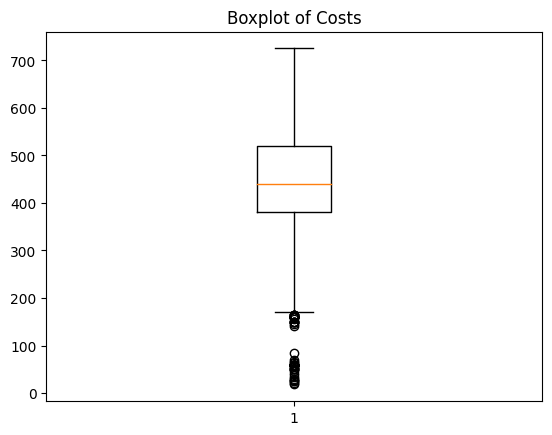

In [14]:
plt.boxplot(df['cost'])
plt.title('Boxplot of Costs')
plt.savefig('./models/cost_boxplot.png')

#### From the 2 plots, we can see that there are a lot of outliers with low costs. They may be associated with the many storage units in listing.

### OLS Regression based on POI

In [15]:
def get_stats():
    x = df[ls]
    y = df['cost']
    results = sm.OLS(y, x).fit()
    print(results.summary())

In [16]:
get_stats()

                                 OLS Regression Results                                
Dep. Variable:                   cost   R-squared (uncentered):                   0.825
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              99.96
Date:                Thu, 29 Sep 2022   Prob (F-statistic):                        0.00
Time:                        17:26:10   Log-Likelihood:                         -39924.
No. Observations:                5978   AIC:                                  8.039e+04
Df Residuals:                    5708   BIC:                                  8.220e+04
Df Model:                         270                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

The OLS model has a R^2 of 0.825, which is really good. However, it uses all the features, which loses out on generalisation.

### Modelling (reduced)

We now try and fit an elastic net regression model on the data.

#### Perform a grid search through values for alpha and penalty parameters of elastic net to find optimal values.

In [ ]:
X, y = df.iloc[:,1:-1], df.iloc[:,-1]
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1, 0.1)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=2)
# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

### Create the elastic net model with optimal parameters

In [17]:
x = df[ls]
y = df['cost']

In [18]:
# Scale the columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x)

In [19]:
net = ElasticNet(random_state=0, alpha=0.1, l1_ratio=0)
cross_validate(net, df_scaled, y, cv=10, n_jobs=2, scoring='r2')

{'fit_time': array([1.07925248, 1.06524754, 1.09465003, 1.07364035, 1.06525445,
        1.08824873, 1.06227756, 1.0852685 , 1.05905747, 1.06406069]),
 'score_time': array([0.00099778, 0.00100327, 0.00099707, 0.00105929, 0.00099373,
        0.        , 0.00099683, 0.        , 0.0009923 , 0.        ]),
 'test_score': array([-11.37857251, -64.690108  , -68.86075316, -97.15925732,
        -59.61938552, -55.7494883 , -22.03628535, -29.94174029,
        -40.55620691, -39.34240363])}

We can see that the variance of the R^2 value across the validation runs is very high.

In [20]:
net.fit(df_scaled,y)

c:\Users\aranw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e+07, tolerance: 7.635e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1, l1_ratio=0, random_state=0)

In [21]:
coefs = net.coef_
remove_list = []
for i in range(len(coefs)):
    if abs(coefs[i]) < 0.05:
        remove_list.append(ls[i])

In [22]:
remove_list

['bar', 'erotic', 'radiotechnics']

In [23]:
len(remove_list)

3

In [24]:
columns = list(chain.from_iterable([['coordinates'],ls]))

In [25]:
df_reduce = df[columns].drop(remove_list, axis=1)

In [26]:
df_unique = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [41]:
df_unique[df_unique['Counts'] <= 5]

,Counts
agrarian,4
aerodrome,3
theme_park,4
locksmith,5
coworking_space,4
...,...
summer_camp,2
brewing_supplies,2
perfumery,2
pillory,2


#### There are quite a lot of features with few unique values. Most of these could be noise to the data, and will need to be filtered out.

In [40]:
remove_list = list(df_unique[df_unique['Counts'] <= 5].index)

In [42]:
df_reduce = df_reduce.drop(remove_list, axis=1)

In [43]:
df_reduce

,coordinates,pitch,water,school,swimming_pool,parking,social_facility,fuel,mall,hardware,...,curtain,zoo,dojo,cannon,retirement_home,general,tiles,bird_hide,estate_agent,bus_station
0,"[-36.253557, 144.944557]",12.0,16.0,2.0,8.0,6.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"[-36.554159, 146.7208003]",47.0,23.0,3.0,19.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"[-36.5530096, 146.7188613]",47.0,21.0,3.0,18.0,16.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"[-36.5380049, 145.9927626]",7.0,9.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"[-36.5424309, 145.9979175]",5.0,15.0,3.0,1.0,21.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5973,"[-37.8802849, 147.8299957]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5974,"[-37.8791032, 147.8273685]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5975,"[-38.1336473, 144.7061689]",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5976,"[-38.372703, 144.7856897]",0.0,0.0,0.0,0.0,8.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# For further testing if required
#df_unique2 = pd.DataFrame(df_reduce.nunique(), columns=['Counts'])

In [48]:
df_reduce.to_csv('./data/curated/reduced_POI_optimal_v2.csv')

## Final modelling (all relevant features)

### OLS model

In [362]:
# drop irrelevant columns
SA2_data.drop(columns = ['Median $ 2019'], inplace = True)

KeyError: "['Median $ 2019'] not found in axis"

In [363]:
# rename variable so it can be joined
SA2_data.rename(columns = {'mean price':'mean_price', 'Mean $ 2019': 'Mean_income_2019', '2021 crime rate': 'crime_rate_2021'}, inplace = True)

In [309]:
# segregate all features columns
features_names = list(SA2_data.iloc[[],2:].columns)

In [310]:
features_names

['pop_2021',
 'Area',
 'Children_population',
 'Early_Working_age_population',
 'Prime_Working_age_population',
 'Mature_Working_age_population',
 'Elderly_population',
 'crime_rate_2021',
 'Mean_income_2019']

In [311]:
'+'.join(features_names)

'pop_2021+Area+Children_population+Early_Working_age_population+Prime_Working_age_population+Mature_Working_age_population+Elderly_population+crime_rate_2021+Mean_income_2019'

In [312]:
# generate a simple linear model
OLS_SA2 = ols(
   formula = "mean_price ~ " + ' + '.join(features_names), data = SA2_data
).fit()

In [316]:
OLS_SA2.summary() # summarise model fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     135.6
Date:                Fri, 30 Sep 2022   Prob (F-statistic):           2.90e-26
Time:                        11:21:42   Log-Likelihood:                -1918.8
No. Observations:                 314   AIC:                             3842.
Df Residuals:                     312   BIC:                             3849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          211.6077     24.624      8.593      0.000     163.157     260.059
Mean_income_2019     0.0044      0.000     11.644      0.000       0.004       0.005
==============================================================================
Omnibus:                      186.605   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1576.060
Skew:                           2.357   Prob(JB):                         0.00
Kurtosis:                      12.911   Cond. No.                     2.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [317]:
# perform anova to assess variables 
anova_table_2 = sm.stats.anova_lm(OLS_SA2)

In [318]:
anova_table_2

,df,sum_sq,mean_sq,F,PR(>F)
Mean_income_2019,1.0,1.623336e+06,1.623336e+06,135.581651,2.902455e-26
Residual,312.0,3.735614e+06,1.197312e+04,NaN,NaN


only mean income seems to be significant for forecasting population

### Negative Binomial

In [199]:
# generate a NB model
NB_SA2 = glm(
   formula = "mean_price ~ " + ' + '.join(features_names), data = SA2_data,
family = families.NegativeBinomial()
).fit()

In [200]:
NB_SA2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             mean_price   No. Observations:                  314
Model:                            GLM   Df Residuals:                      305
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2255.3
Date:                Fri, 30 Sep 2022   Deviance:                       12.372
Time:                        10:49:32   Pearson chi2:                     14.6
No. Iterations:                     6   Pseudo R-squ. (CS):            0.02198
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         5.6554      0.321     17.643      0.000       5.027       6.284
pop_2021                       1.489e-05    9.1e-05      0.164      0.870      -0.000       0.000
Area                          -2.678e-05   5.19e-05     -0.516      0.606      -0.000    7.49e-05
Children_population            -1.88e-05   9.34e-05     -0.201      0.841      -0.000       0.000
Early_Working_age_population  -2.379e-05      0.000     -0.164      0.870      -0.000       0.000
Prime_Working_age_population  -7.983e-06   6.74e-05     -0.118      0.906      -0.000       0.000
Mature_Working_age_population  9.321e-05      0.000      0.385      0.700      -0.000       0.001
Elderly_population            -1.287e-05      0.000     -0.114      0.909      -0.000       0.000
crime_rate_2021                  -0.2294      2.525     -0.091      0.928      -5.179       4.720
Mean_income_2019               8.498e-06   3.62e-06      2.349      0.019    1.41e-06    1.56e-05
=================================================================================================
"""

it seems that a OLS is more appropriate with only income as the only predictor

### testing

In this section we will be testing OLS and NB models through cross validation

In [201]:
# reset index
SA2_data.reset_index(inplace = True)

In [202]:
# list to store error rates
OLS_error = []
NB_error = []

# we will perform a one part out cross validation 
for i in range(len(SA2_data)):
    # take out one part for testing
    test = SA2_data.iloc[[i],]
    # rest for training
    train = SA2_data[SA2_data.index !=i]
    
    # fit OLS model 
    OLS_income = ols(
       formula = "mean_price ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
        ).fit()
    # fit NB model
    NB_income =glm(
   formula = "mean_price ~ Mean_income_2019", data = train,
    family = families.NegativeBinomial()
    ).fit()
    
    # output accuracy scores into pd frame '
    OLS_error.append(float(OLS_income.predict(test) - test['mean_price']))
    NB_error.append(float(NB_income.predict(test) - test['mean_price']))




/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/lucyliu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)
/Users/luc

In [203]:
# create pandas frame to store results
Results_CV = pd.DataFrame()

# write results error in

Results_CV['OLS error'] = OLS_error
Results_CV['NB error'] = NB_error

In [204]:
# change all to absolute values
Results_CV['OLS error'] = abs(Results_CV['OLS error'])
Results_CV['NB error'] = abs(Results_CV['NB error'])

In [205]:
# examine the errors -OLS
print('mean of OLS errors is', Results_CV['OLS error'].mean())
print('sd of OLS errors is', Results_CV['OLS error'].std())

mean of OLS errors is 72.50881893305
sd of OLS errors is 83.04926455781289


In [206]:
# examine NB errors
print('mean of NB errors is', Results_CV['NB error'].mean())
print('sd of NB errors is', Results_CV['NB error'].std())

mean of NB errors is 75.2747377509845
sd of NB errors is 93.54365980399706


the OLS model seems to be a better fit in this case, so we will use this for our forecasts

## Future data

In [341]:
# read in future data for income
future_income_data=pd.read_csv('data/curated/forecast_income_SA2.csv')

In [342]:
future_income_data

,Unnamed: 0,SA2_NAME,2020,2021,2022,2023,2024,2025
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5
2,2,Ballarat - North,122800.0,125235.4,127719.1,130252.0,132835.2,135469.5
3,3,Ballarat - South,50193.7,52038.9,53951.9,55935.2,57991.5,60123.3
4,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7
...,...,...,...,...,...,...,...,...
457,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2
458,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5
459,459,Moyne - West,50606.0,51525.5,52461.6,53414.8,54385.2,55373.4
460,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0


In [343]:
SA2_data.reset_index(inplace = True)

In [353]:
# new df with only relevant data
SA2_data_relevant = pd.DataFrame()
SA2_data_relevant['SA2'] = SA2_data['SA2 name']
SA2_data_relevant['mean_price']=SA2_data['mean_price']

In [354]:
# merge df
future_income_data=future_income_data.merge(SA2_data_relevant, how = 'inner', left_on = 'SA2_NAME', right_on = 'SA2')

In [355]:
future_income_data

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2_x,Mean_rent,SA2_y,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857,Warrnambool - North,367.142857


In [356]:
future_income_data

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2_x,Mean_rent,SA2_y,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857,Warrnambool - North,367.142857


In [357]:
future_income_data.dropna() # are there anymore NA values

,Unnamed: 0,SA2_NAME,Mean_income_2020,Mean_income_2021,Mean_income_2022,Mean_income_2023,Mean_income_2024,Mean_income_2025,SA2_x,Mean_rent,SA2_y,mean_price
0,0,Alfredton,81603.0,85174.8,88902.9,92794.2,96855.8,101095.2,Alfredton,423.421053,Alfredton,423.421053
1,1,Ballarat,67662.9,70214.6,72862.5,75610.2,78461.6,81420.5,Ballarat,398.928571,Ballarat,398.928571
2,4,Buninyong,65636.4,67665.6,69757.6,71914.3,74137.6,76429.7,Buninyong,410.000000,Buninyong,410.000000
3,5,Delacombe,87498.9,90983.2,94606.2,98373.6,102290.9,106364.3,Delacombe,440.000000,Delacombe,440.000000
4,7,Wendouree - Miners Rest,36547.4,39749.9,43232.9,47021.1,51141.3,55622.5,Wendouree - Miners Rest,357.916667,Wendouree - Miners Rest,357.916667
...,...,...,...,...,...,...,...,...,...,...,...,...
309,455,Corangamite - North,104078.6,108804.4,113744.8,118909.5,124308.8,129953.2,Corangamite - North,340.000000,Corangamite - North,340.000000
310,457,Otway,49889.2,51292.7,52735.8,54219.5,55744.9,57313.2,Otway,395.000000,Otway,395.000000
311,458,Moyne - East,86502.6,90012.0,93663.8,97463.8,101417.9,105532.5,Moyne - East,300.000000,Moyne - East,300.000000
312,460,Warrnambool - North,56678.5,61222.3,66130.4,71431.9,77158.4,83344.0,Warrnambool - North,367.142857,Warrnambool - North,367.142857


In [358]:
# rename columns 
for i in range(2020,2026): 
    future_income_data=future_income_data.rename(columns = {str(i): 'Mean_income_' + str(i)})

In [359]:
# let's fit the model with the 2022 data
OLS_SA2_2022 = ols(
   formula = "mean_price ~ Mean_income_2021", data = future_income_data
).fit()

In [360]:
OLS_SA2_2022.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.785
Date:                Fri, 30 Sep 2022   Prob (F-statistic):             0.0295
Time:                        11:32:08   Log-Likelihood:                -1973.1
No. Observations:                 314   AIC:                             3950.
Df Residuals:                     312   BIC:                             3958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          429.0057     28.468     15.070      0.000     372.992     485.019
Mean_income_2021     0.0009      0.000      2.187      0.029    9.12e-05       0.002
==============================================================================
Omnibus:                      106.322   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.970
Skew:                           1.531   Prob(JB):                     3.31e-70
Kurtosis:                       6.884   Cond. No.                     2.66e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.66e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R squared value is much lower when using supposedly current income data, this suggests that perhaps rental prices are adjusted at a slower rate than income ie. average income is refleceted years later in the rental prices, hence we will keep the model as it is where income 3 years ago is used to foreecast the most current years' prices of rent per SA2

## forecasting

In [369]:
SA2_data.rename(columns = {'Mean_income_2019': 'Mean_income'}, inplace = True) # rename to fit general model

In [370]:
# create final model
OLS_final = ols(formula = 'mean_price ~ Mean_income', data = SA2_data).fit()

In [376]:
# df to store predictions
Predictions = pd.DataFrame()
Predictions['SA2'] = future_income_data['SA2_NAME']
# predict for the next three years; iterative
for i in range(2023,2026): 
    df = pd.DataFrame()
    df['Mean_income'] = future_income_data['Mean_income_' +str(i)]
    Predictions[str(i)] = OLS_final.predict(df).astype(float)
    

    
    


In [377]:
Predictions

,SA2,2023,2024,2025
0,Alfredton,615.761044,633.450827,651.914995
1,Ballarat,540.918316,553.337227,566.224340
2,Buninyong,524.821294,534.504594,544.487545
3,Delacombe,640.061412,657.122714,674.863890
4,Wendouree - Miners Rest,416.402125,434.347133,453.864430
...,...,...,...,...
309,Corangamite - North,729.502914,753.018879,777.602346
310,Otway,447.753841,454.397527,461.228059
311,Moyne - East,636.098894,653.320474,671.241091
312,Warrnambool - North,522.720262,547.661305,574.601899
